In [2]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role


In [6]:
hyperparameters = {"epochs": "2", "batch-size": "32", "test-batch-size": "100", "lr": "0.001"} 

estimator = PyTorch(
    entry_point="scripts/pytorch_cifar.py",
    base_job_name="sagemaker-script-mode",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
)


In [7]:
estimator.fit(wait=True)

2021-12-19 01:40:54 Starting - Starting the training job...
2021-12-19 01:41:18 Starting - Launching requested ML instancesProfilerReport-1639878053: InProgress
......
2021-12-19 01:42:19 Starting - Preparing the instances for training.........
2021-12-19 01:43:39 Downloading - Downloading input data...
2021-12-19 01:44:19 Training - Downloading the training image...
2021-12-19 01:44:54 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-19 01:44:54,817 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-19 01:44:54,820 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-19 01:44:54,829 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-19 01:44:56,248 sagemaker_pytorch_container.training INFO     Invoking user training sc

In [8]:
estimator.hyperparameters()

{'epochs': '"2"',
 'batch-size': '"32"',
 'test-batch-size': '"100"',
 'lr': '"0.001"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-755391689112/sagemaker-script-mode-2021-12-19-01-40-53-305/source/sourcedir.tar.gz"',
 'sagemaker_program': '"pytorch_cifar.py"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"sagemaker-script-mode-2021-12-19-01-40-53-305"',
 'sagemaker_region': '"us-east-1"'}

In [9]:
estimator.model_data

's3://sagemaker-us-east-1-755391689112/sagemaker-script-mode-2021-12-19-01-40-53-305/output/model.tar.gz'

In [10]:
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 270 kB 7.9 MB/s            
     |████████████████████████████████| 83 kB 167 kB/s             


In [11]:
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
)

In [12]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

In [13]:
hook_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

In [14]:
estimator = PyTorch(
    entry_point="scripts/pytorch_cifar.py",
    base_job_name="smdebugger-cifar-pytorch",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    framework_version="1.8",
    py_version="py36",
    ## Debugger parameters
    rules=rules,
    debugger_hook_config=hook_config,
)

In [15]:
estimator.fit(wait=True)

2021-12-19 01:52:00 Starting - Starting the training job...
2021-12-19 01:52:31 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport-1639878720: InProgress
......
2021-12-19 01:53:31 Starting - Preparing the instances for training.........
2021-12-19 01:54:56 Downloading - Downloading input data...
2021-12-19 01:55:32 Training - Downloading the training image.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-12-19 01:56:09,957 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-12-19 01:56:09,961 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-19 01:56:09,975 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-12-19 01:56:11,391 sagemaker_pytorch_container.training INFO     

In [16]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [24]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-12-19 02:13:20.381 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-755391689112/smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/debug-output


In [25]:
trial.tensor_names()

[2021-12-19 02:13:24.270 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-12-19 02:13:25.294 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:21 INFO trial.py:210] Loaded all steps


['gradient/Net_conv1.bias',
 'gradient/Net_conv1.weight',
 'gradient/Net_conv2.bias',
 'gradient/Net_conv2.weight',
 'gradient/Net_fc1.bias',
 'gradient/Net_fc1.weight',
 'gradient/Net_fc2.bias',
 'gradient/Net_fc2.weight',
 'nll_loss_output_0']

In [37]:
len(trial.tensor('nll_loss_output_0').steps(mode=ModeKeys.TRAIN))

0

In [27]:
len(trial.tensor("nll_loss_output_0").steps(mode=ModeKeys.EVAL))

0

In [21]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


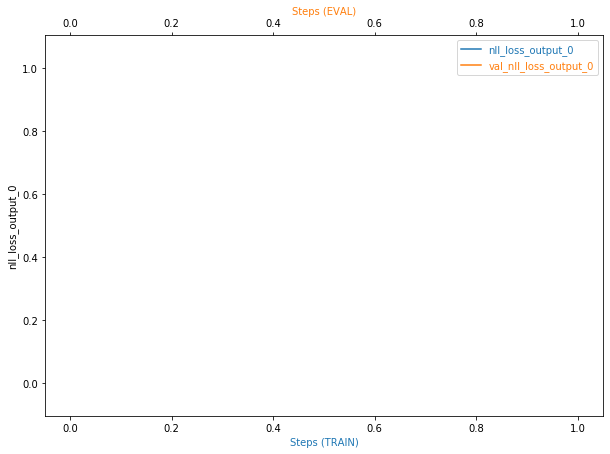

In [23]:
plot_tensor(trial, "nll_loss_output_0")

In [38]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [39]:
! aws s3 ls {rule_output_path} --recursive

2021-12-19 02:01:22     329728 smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-report.html
2021-12-19 02:01:21     171103 smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-report.ipynb
2021-12-19 02:01:18        191 smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/BatchSize.json
2021-12-19 02:01:18        199 smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/CPUBottleneck.json
2021-12-19 02:01:18        126 smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/Dataloader.json
2021-12-19 02:01:18        127 smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-12-19 0

In [40]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-755391689112/smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/BatchSize.json to ProfilerReport-1639878720/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-755391689112/smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport-1639878720/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-755391689112/smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport-1639878720/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-755391689112/smdebugger-cifar-pytorch-2021-12-19-01-52-00-173/rule-output/ProfilerReport-1639878720/profiler-output/profiler-reports/Dataloader.json to ProfilerR

In [41]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [42]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")